In [4]:
%load_ext autoreload
%autoreload 2

import roboscientist
from roboscientist import datasets
from roboscientist.datasets import equations_settings
import sympy as snp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from roboscientist.datasets.equations_utils import expr_to_tree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Polynomial equation

In [5]:
np.random.seed(1337)
equation = datasets.generate_polynomial(nodes=40, n_variables=1)
print(equation)
equation

2*x0**4 + 11*x0**3 + 23*x0**2 + 15*x0 + 3


Add(Mul(Integer(2), Pow(Symbol('x0'), Integer(4))), Mul(Integer(11), Pow(Symbol('x0'), Integer(3))), Mul(Integer(23), Pow(Symbol('x0'), Integer(2))), Mul(Integer(15), Symbol('x0')), Integer(3))

In [6]:
equation.expr

2*x0**4 + 11*x0**3 + 23*x0**2 + 15*x0 + 3

In [7]:
X = np.linspace(-3, 3, 100).reshape(-1, 1)
y = equation(X)

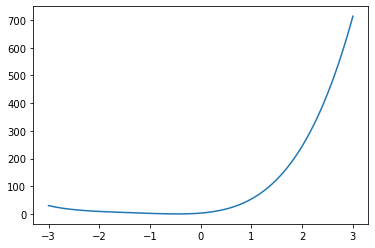

In [9]:
plt.plot(X.reshape(-1, 1), y)

In [10]:
print(equation.postfix, equation.variables)

([3.0, 2.0, 'x0', 4.0, 'Pow', 'Mul', 11.0, 'x0', 3.0, 'Pow', 'Mul', 15.0, 'x0', 'Mul', 23.0, 'x0', 2.0, 'Pow', 'Mul', 'Add'], [0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 5]) [x0]


In [11]:
D, _ = expr_to_tree(snp.expand(equation._expr))

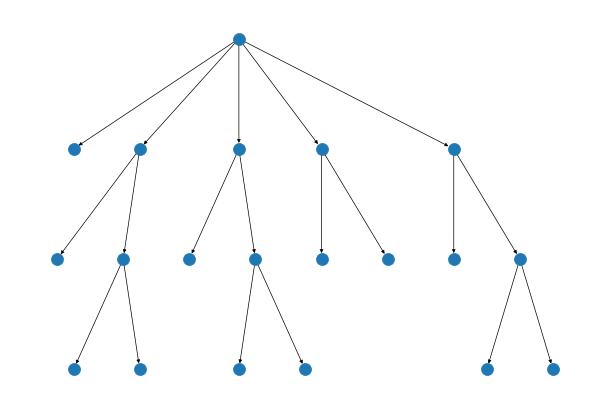

In [12]:
plt.figure(figsize=(12, 8), dpi=50)
pos = graphviz_layout(D, prog="dot")
nx.draw(D, pos)
plt.show()

## General equation

In [13]:
np.random.seed(1389)
equation = datasets.generate_random_equation(nodes=15, n_variables=3, max_degree=2)
equation

Add(Mul(Symbol('x1'), Add(Symbol('x0'), Integer(1)), sin(sin(Add(cos(Symbol('x0')), Integer(1))))), cos(Integer(1)))

In [14]:
X = np.random.randn(100, len(equation.variables))
y = equation(X)

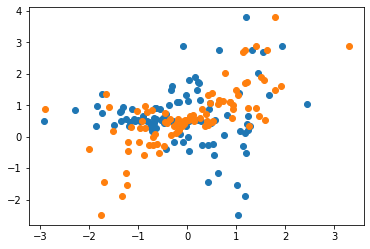

In [15]:
plt.scatter(X[:, 0], y); plt.scatter(X[:, 1], y);

In [16]:
print(equation.postfix, equation.variables)

(['x1', 1.0, 'x0', 'Add', 1.0, 'x0', 'cos', 'Add', 'sin', 'sin', 'Mul', 1.0, 'cos', 'Add'], [0, 0, 0, 2, 0, 0, 1, 2, 1, 1, 3, 0, 1, 2]) [x0, x1]


In [17]:
D, _ = expr_to_tree(equation._expr)

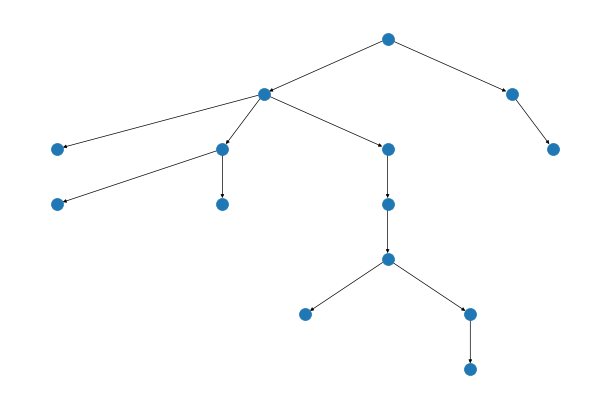

In [18]:
plt.figure(figsize=(12, 8), dpi=50)
pos = graphviz_layout(D, prog="dot")
nx.draw(D, pos)
plt.show()

In [11]:
from roboscientist.models import brute_force

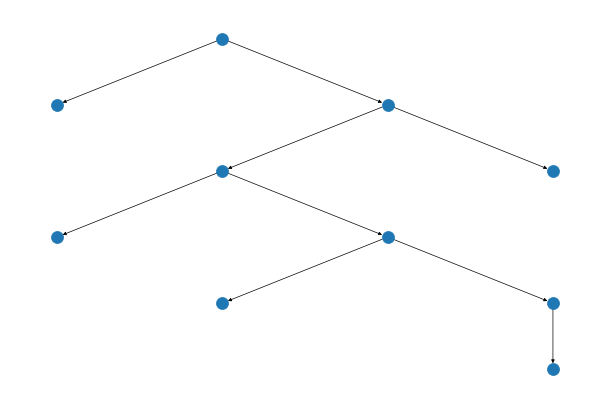

In [12]:
plt.figure(figsize=(12, 8), dpi=50)
pos = graphviz_layout(D, prog="dot")
nx.draw(D, pos)
plt.show()

In [13]:
from sympy.utilities.lambdify import lambdify

In [67]:
equation = datasets.generate_polynomial(nodes=40, n_variables=1)

In [48]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [195]:
from scipy.optimize import minimize
from functools import partial

def _optimize_constants(constants, X, y, equation):
    y_hat = equation.func(X, constants)
    loss = (np.real((y_hat - y)**2)).mean()
    return np.abs(loss)

def optimize_constants(candidate_equation, X, y, n_restarts):
    """
    Optimize all available constants in the equation
    """
    # is has constants
    best_loss = 1e10
    best_constants = None
    err = None
    
    if candidate_equation.constants:
        for restart in range(n_restarts):
            try:
                res = minimize(
                    partial(_optimize_constants, X=X + 0j, y=y, equation=candidate_equation), 
                    np.random.uniform(low=1, high=2, size=len(candidate_equation.constants))
                )
                fun = res.fun
                consts = res.x
                if res.fun < best_loss:
                    best_loss = res.fun
                    best_constants = res.x
                    
            except ValueError:
                pass
        if best_constants is None:
            return None, None, "Err"
        else:
            candidate_equation = candidate_equation.subs(best_constants)
    else:
        y_hat = candidate_equation.func(X + 0j)
        best_loss = (np.real((y_hat - y)**2)).mean()
        if best_loss is None:
            return None, None, "Err"
        
    return best_loss, candidate_equation, None

In [202]:
from tqdm import tqdm

n = 0
best_loss = 1e9
best_equation = None
for candidate_equation in tqdm(brute_force.brute_force_solver(11, n_symbols=1)):
    loss, candidate_equation, err = optimize_constants(candidate_equation, X, y, n_restarts=5)
    if err:
        continue
    else:
        if loss < best_loss:
            best_loss = loss
            best_equation = candidate_equation
            print(best_loss, best_equation)

16it [00:00, 68.94it/s]

5111.907693994985 sin(x0)
4146.315337583837 32.0210428819614
4146.315337583836 32.0210414780829
4069.433477423393 x0 + 31.5210412931233
2209.769139158933 54.0156084580691*x0
213.9604915838263 x0**8.39364498533269


27it [00:00, 58.13it/s]

27.205724394297917 16.9242406895514**x0


65it [00:01, 33.53it/s]

27.20572439429791 16.9242407212569**x0


161it [00:04, 39.82it/s]


KeyboardInterrupt: 

In [201]:
candidate_equation.expr

const0**(sqrt(x0))

In [197]:
best_equation

16.9242406933263**x0

In [199]:
snp.expand(equation.expr)

3*x0**6 + 2*x0**5 + 2*x0**4 + x0**2

In [177]:
((np.real(y - min_expr[0].func(X + 0j, min_expr[1])))**2).mean()

1.4366521660299079

In [162]:
min_expr[0].constants

[const1, const0]

In [160]:
min_expr

(Pow(Add(Symbol('const0'), Symbol('x0')), Symbol('const1')),
 array([0.37341773, 6.56881952]))

In [51]:
equation_with_const = expr

In [68]:
equation_with_const.derivative_wrt_constants(X, [2., 1.2])

[array([0.        , 0.01017228, 0.02048651, 0.03094179, 0.04153726,
        0.05227206, 0.06314534, 0.07415627, 0.08530403, 0.09658781,
        0.10800682, 0.11956027, 0.13124739, 0.14306741, 0.15501959,
        0.16710318, 0.17931746, 0.1916617 , 0.2041352 , 0.21673725,
        0.22946716, 0.24232425, 0.25530785, 0.26841729, 0.28165192,
        0.29501109, 0.30849416, 0.3221005 , 0.33582949, 0.34968052,
        0.36365297, 0.37774626, 0.39195978, 0.40629295, 0.42074519,
        0.43531594, 0.45000462, 0.46481069, 0.47973359, 0.49477277,
        0.5099277 , 0.52519785, 0.54058269, 0.5560817 , 0.57169436,
        0.58742017, 0.60325863, 0.61920924, 0.6352715 , 0.65144494,
        0.66772906, 0.6841234 , 0.70062749, 0.71724085, 0.73396302,
        0.75079356, 0.767732  , 0.78477791, 0.80193084, 0.81919036,
        0.83655602, 0.8540274 , 0.87160409, 0.88928565, 0.90707167,
        0.92496174, 0.94295545, 0.9610524 , 0.97925218, 0.99755441,
        1.01595868, 1.03446462, 1.05307183, 1.07

In [71]:
y - equation_with_const.func(X, [2., 2.])

array([  5.        ,   5.37158399,   5.7594332 ,   6.16411347,
         6.58620538,   7.02630454,   7.48502183,   7.96298363,
         8.46083216,   8.97922567,   9.51883876,  10.08036264,
        10.66450538,  11.27199224,  11.90356588,  12.5599867 ,
        13.24203308,  13.9505017 ,  14.68620781,  15.44998553,
        16.24268811,  17.06518829,  17.91837852,  18.80317132,
        19.72049956,  20.67131674,  21.65659734,  22.67733711,
        23.73455336,  24.82928531,  25.96259437,  27.1355645 ,
        28.34930248,  29.60493827,  30.90362532,  32.24654089,
        33.63488641,  35.06988776,  36.55279566,  38.08488597,
        39.66746003,  41.30184502,  42.98939429,  44.73148769,
        46.52953197,  48.38496106,  50.29923647,  52.27384764,
        54.31031227,  56.4101767 ,  58.57501629,  60.80643574,
        63.10606947,  65.47558203,  67.91666841,  70.43105444,
        73.02049717,  75.68678524,  78.43173927,  81.25721223,
        84.16508982,  87.15729086,  90.23576771,  93.40

In [185]:
candidate_equation.subs([1.])

1.0*cos(sin(x0))

In [107]:
X = np.linspace(-1., 2., 100).reshape(-1, 1)
y = equation.func(X)

In [108]:
equation_with_const.expr

const0 + x0**const1

(4858.343396798671+0j)
(4858.343395934229+0j)
(4858.343395162502+8.684823547535834e-09j)
(4702.082163445777-0.009838673540240598j)
(4702.08216260126-0.009838672657261262j)
(4702.082160677462-0.009838672951264919j)
(2491.4256408700035+0.16751498498202275j)
(2491.425640291937+0.16751498644450244j)
(2491.4256222245413+0.16751498267921697j)
(65745638428.07205+0.22864639608050236j)
(65745638428.07394+0.22864639651171184j)
(65745639753.65275+0.22864638438375517j)
(90487.67254924309+0.028983905714634144j)
(90487.67255205436+0.028983905858403027j)
(90487.67470803583+0.02898389648513978j)
(657.0854238431256-0.158477751373959j)
(657.0854235556445-0.15847775228590175j)
(657.0854043688958-0.15847774495847075j)
(2664.989173334123-0.10483078586377577j)
(2664.989173778909-0.10483078653391367j)
(2664.989287051661-0.10483079299748685j)
(188.8394380969806+0.1612504503044302j)
(188.83943799405307+0.16125045115865913j)
(188.83943257586648+0.16125045656552023j)
(168.2772880958661+0.19761301507548915j)
(168

In [110]:
res

      fun: 164.08999466933645
 hess_inv: array([[ 5.62129589e-01, -4.31400493e-03],
       [-4.31400493e-03,  2.98833686e-04]])
      jac: array([-1.90734863e-06,  7.62939453e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 6
     njev: 17
   status: 0
  success: True
        x: array([7.48750435, 8.33738272])

In [111]:
(-5)**(-1/12)

(0.8446879091478524-0.2263334431125006j)

In [113]:
res.x

array([7.48750435, 8.33738272])

In [122]:
s = "Pow(Mul(Integer(3), Symbol('const')), Add(Symbol('const'), Symbol('const')))"

In [134]:
const_counter = 0
def enumerate_constant(match):
    global const_counter
    print(type(match.group()))
    print(const_counter)
    const_counter += 1
    return match

re.sub(r"Symbol\('const'\)", enumerate_constant, s)

<class 'str'>
0
<class 'str'>
1
<class 'str'>
2


TypeError: sequence item 1: expected str instance, re.Match found

In [128]:
re.findall(r"Symbol\('const'\)", s)

["Symbol('const')", "Symbol('const')", "Symbol('const')"]

In [104]:
import re

In [121]:
s

"Pow(Mul(Integer(3), Symbol('c')), Add(Symbol('c'), Symbol('x0')))"

In [49]:
all([False])

False

In [103]:
start = 10
step = 3

In [104]:
for i in range(5):
    print(start + i * step, end=', ')

10, 13, 16, 19, 22, 